In [2]:
!pip install --upgrade pip
!pip install pandas numpy scikit-learn scipy graphviz shap matplotlib

In [3]:
# Data Processing
import pandas as pd
import numpy as np

from shap import TreeExplainer
from shap import summary_plot, force_plot

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

/home/sebastian/mobemu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# fraction = 0.25

# sampled_chunks = []
# chunk_size = 1000000

# for i, chunk in enumerate(pd.read_csv('traces/upb-hyccups2012/upb2012.csv', chunksize=chunk_size)):
#     if i > 3:
#         break
#     # Sample a fraction of rows from each chunk
#     sampled_chunk = chunk.sample(frac=fraction, random_state=1)
#     sampled_chunks.append(sampled_chunk)
# df = pd.concat(sampled_chunks, ignore_index=True)


df = pd.read_csv("traces/upb-hyccups2012/upb2012.csv", nrows=50000)

In [5]:
df

,messageId,messageSource,messageHopCount,oldRelayId,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newRelayId,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory
0,0,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000
1,1,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000
2,2,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000
3,3,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000
4,4,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1281,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222
49996,1282,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222
49997,1283,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222
49998,1284,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222


In [6]:
successful_messages = pd.read_csv("traces/upb-hyccups2012/successful2012.csv", nrows=10000)

In [7]:
successful_messages

,messageId,lastRelay,destination
0,14,5,0
1,579,5,0
2,595,5,0
3,604,6,1
4,1176,6,1
...,...,...,...
9995,1797,4,0
9996,1798,4,0
9997,1291,4,0
9998,1864,4,0


In [8]:
df["usefulTransfer"] = np.NaN
df

,messageId,messageSource,messageHopCount,oldRelayId,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newRelayId,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory,usefulTransfer
0,0,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000,NaN
1,1,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000,NaN
2,2,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000,NaN
3,3,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000,NaN
4,4,0,1,5,0,0.333218,0,1.0,0,0,0.730968,0,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1281,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222,NaN
49996,1282,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222,NaN
49997,1283,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222,NaN
49998,1284,5,2,0,0,0.730968,0,1.0,2,0,0.637417,0,0.222,NaN


In [9]:
# make sure column is integer not float
df["usefulTransfer"] = pd.Series(dtype=np.int64)

for index, row in successful_messages.iterrows():
  message_id = row.iloc[0]
  last_relay = row.iloc[1]
  destination = row.iloc[2]

  reached_source = False
  queue = df[(df['messageId'] == message_id) & (df['newRelayId'] == last_relay)].index.tolist()
  visited = []
  while (True):
    if (len(queue) == 0):
       break

    curr_idx = queue.pop()
    visited.append(curr_idx)

    df_row = df.iloc[curr_idx]
    message_source = df_row.iloc[1]
    old_relay_id = df_row.iloc[3]

    if old_relay_id == message_source:
        break

    df.loc[curr_idx, "usefulTransfer"] = 1
    last_relay = old_relay_id


    for idx in df[(df['messageId'] == message_id) & (df['newRelayId'] == last_relay)].index.tolist():
       if (idx not in visited):
         queue.insert(0, idx)

df.loc[(df['usefulTransfer'] != 1), 'usefulTransfer'] = 0
df = df.drop(columns=['messageId', 'oldRelayId', 'newRelayId', 'messageSource'])
df['usefulTransfer'].value_counts()[1]


2663

In [10]:
df.to_csv('traces/upb-hyccups2012/with_result.csv', index=False)


In [11]:
positive_df = df.loc[df['usefulTransfer'] == 1]
negative_df = df.loc[df['usefulTransfer'] == 0].sample(len(positive_df))
balanced_df = pd.concat([positive_df, negative_df], ignore_index=True)
balanced_df

,messageHopCount,oldFriendWithDestination,oldRelayBattery,oldCommonCommunity,oldDataMemory,newFriendWithDestination,newRelayBattery,newCommonCommunity,newDataMemory,usefulTransfer
0,0,0,0.730968,1,1.0,1,0.637417,0,0.001,1.0
1,0,0,0.730968,1,1.0,1,0.637417,0,0.009,1.0
2,0,0,0.730968,1,1.0,1,0.637417,0,0.019,1.0
3,2,0,0.730968,0,1.0,0,0.637417,0,0.041,1.0
4,2,0,0.637417,0,1.0,0,0.730968,0,0.047,1.0
...,...,...,...,...,...,...,...,...,...,...
5321,6,0,0.385189,0,1.0,0,0.240536,0,0.579,0.0
5322,3,0,0.385189,0,1.0,0,0.240536,0,0.579,0.0
5323,2,0,0.637417,0,1.0,0,0.730968,0,0.262,0.0
5324,2,0,0.385189,0,1.0,0,0.240536,0,0.589,0.0


In [12]:
X = balanced_df.iloc[:, :-1]  # All columns except the last one
y = balanced_df.iloc[:, -1]   # Only the last column

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88       520
         1.0       0.85      0.94      0.89       546

    accuracy                           0.88      1066
   macro avg       0.89      0.88      0.88      1066
weighted avg       0.89      0.88      0.88      1066

Confusion Matrix:
[[432  88]
 [ 35 511]]


In [14]:
explainer = TreeExplainer(rf_classifier)
shap_values = np.array(explainer.shap_values(X_test))
print(shap_values.shape)
print(X_test.shape)

(1066, 9, 2)
(1066, 9)


In [22]:
truncated_shap = shap_values[:20][:][:]
truncated_x = X_test.head(20)

print(truncated_shap.shape)
print(truncated_x.shape)

(20, 9, 2)
(20, 9)


In [23]:
force_plot(explainer.expected_value[0], truncated_shap, truncated_x)

IndexError: list index out of range

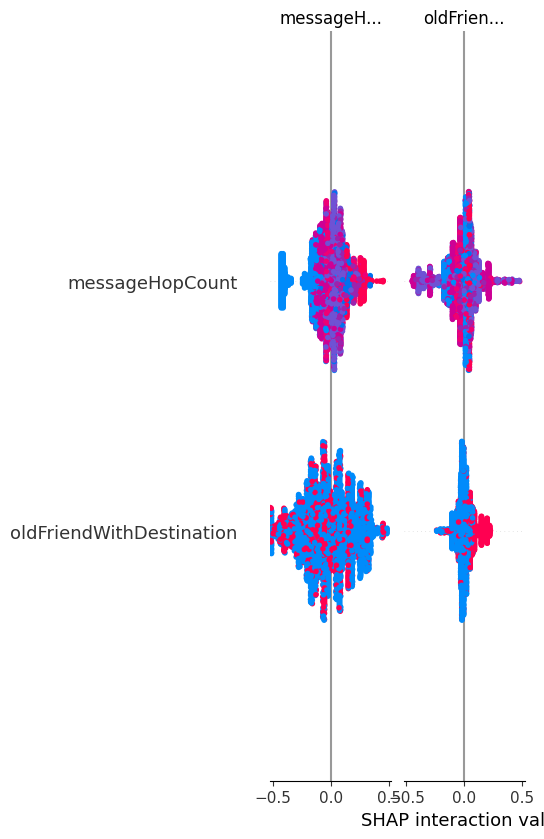

In [ ]:
summary_plot(shap_values, X, feature_names=rf_classifier.feature_names_in_,max_display=30 , class_names=rf_classifier.classes_, plot_type='dot', show = False)
